In [2]:
from cc.env.collect import sample_feedforward_and_collect
from cc.env import make_env
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.train import (
    ModelControllerTrainer, TrainingOptionsModel, 
    EvaluationMetrices, Tracker, make_dataloader, DictLogger,
    Regularisation, SupervisedDataset
)
import jax.random as jrand
from cc.utils import rmse, l2_norm
import optax
import jax.numpy as jnp

/data/ba54womo/miniforge3/lib/python3.10/site-packages/glfw/__init__.py:912: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/ba54womo/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
time_limit = 10.0
control_timestep = 0.01

env = make_env("two_segments_v1", time_limit=time_limit, control_timestep=control_timestep, random=1)

In [5]:
sample_train = sample_feedforward_and_collect(
    env,
    #seeds_gp=[0,1,2,3,4,5,6,7,8,9,10,11],
    #seeds_cos=[1,2,3,4,5,6,7,8,9,10,12,14]
    seeds_gp=list(range(0, 30)),
    seeds_cos=list(range(1,31))
)

sample_val = sample_feedforward_and_collect(
    env, 
    seeds_gp=[15, 16, 17, 18],
    seeds_cos=[2.5, 5.0, 7.5, 10.0]
)

In [6]:
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep,
    state_dim=100,
    f_depth=0, 
    u_transform=jnp.arctan
)

In [7]:
model_train_dataloader = make_dataloader(
    SupervisedDataset(sample_train.action, sample_train.obs), # <- (X, y)
    jrand.PRNGKey(2,), 
    n_minibatches=4
)

optimizer = optax.adam(1e-3)

regularisers = (
    Regularisation(
        prefactor = 0.5,
        reduce_weights = lambda vector_of_params: {"l2_norm": l2_norm(vector_of_params)}
    ),
)

metrices = (
    EvaluationMetrices(
        data = (sample_val.action, sample_val.obs), # <- (X, y)
        metrices=(
            lambda y, yhat: {"val_rmse": rmse(y, yhat)}, 
        )
    ),
)

model_train_options = TrainingOptionsModel(
    model_train_dataloader, 
    optimizer, 
    regularisers=regularisers,
    metrices=metrices
)

model_trainer = ModelControllerTrainer(
    model, 
    model_train_options=model_train_options,
    loggers=[DictLogger()],
    trackers=[Tracker("val_rmse")]
)

In [8]:
model_trainer.run(1000)

l2_norm:     3.6977 | train_loss:     2.0159 | train_mse:     0.1671 | val_rmse:     0.5461 | : 100%|██████████| 1000/1000 [12:52<00:00,  1.29it/s]


In [9]:
model_trainer.trackers[0].best_metric()

0.47854003

In [10]:
fitted_model = model_trainer.trackers[0].best_model_or_controller()
import equinox as eqx
eqx.tree_serialise_leaves("good_env1_model2.eqx", fitted_model)

In [ ]:
import numpy as np
import equinox as eqx

action = np.array([0.2])
# this returns a new model with an updated internal state
# and of course the actual prediction of the observation
fitted_model, predicted_obs = eqx.filter_jit(fitted_model.step)(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09587634], dtype=float32))])

In [ ]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09720241], dtype=float32))])

In [ ]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end', DeviceArray([0.0985732], dtype=float32))])

In [ ]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09998906], dtype=float32))])

Finally, you can also replace the `Mujoco` physics component in your environment with your model. 

This creates a new environment that looks exactly the same from outside.

In [ ]:
from cc.env.wrappers import ReplacePhysicsByModelWrapper

env_model = ReplacePhysicsByModelWrapper(env, fitted_model)

In [ ]:
fitted_model.y0()

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09459463], dtype=float32))])

In [ ]:
env_model.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('xpos_of_segment_end', array([0.09459463], dtype=float32))]))

In [ ]:
env_model.step(action)

TimeStep(step_type=<StepType.MID: 1>, reward=array(0., dtype=float32), discount=0.0, observation=OrderedDict([('xpos_of_segment_end', array([0.09587634], dtype=float32))]))

In [ ]:
env_model.step(action)

TimeStep(step_type=<StepType.MID: 1>, reward=array(0., dtype=float32), discount=0.0, observation=OrderedDict([('xpos_of_segment_end', array([0.09720241], dtype=float32))]))

Now that the model is an environment, we can also now use all of our `collect` technology

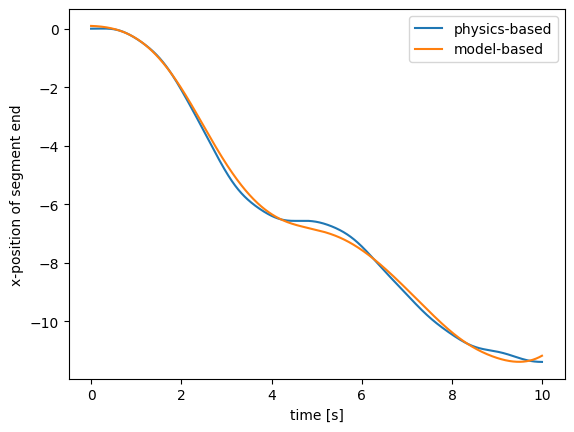

In [ ]:
from cc.examples.feedforward_controller import make_feedforward_controller
from cc.env.collect import collect

controller = make_feedforward_controller(sample_train.action[0])
pred_sample, _ = collect(env_model, controller)

import matplotlib.pyplot as plt 

plt.plot(env.ts, sample_train.obs["xpos_of_segment_end"][0, :-1], label="physics-based")
plt.plot(env.ts, pred_sample.obs["xpos_of_segment_end"][0, :-1], label = "model-based")
plt.xlabel("time [s]")
plt.ylabel("x-position of segment end")
plt.legend()


In [ ]:
# save model for usage in next notebook
eqx.tree_serialise_leaves("model.eqx", fitted_model)

In [ ]:
# reload model
del fitted_model
fitted_model = eqx.tree_deserialise_leaves("model.eqx", model) 